In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Loading 

In [ ]:
sales_df = pd.read_csv('../datasets/predict-sales/sales_train.csv')
items_df = pd.read_csv('../datasets/predict-sales/items.csv')
test_df = pd.read_csv('../datasets/predict-sales/test.csv')

In [ ]:
sales_df.drop(labels=['date'],inplace=True,axis=1)
sales_df = sales_df.reset_index()
items_df.drop(labels=['item_name'],inplace=True,axis=1)

In [ ]:
dict_aux = {}

In [ ]:
def setPair(x, d):
    i = str(x[0]) + '-' + str(x[1])
    try:
        return d[i]
    except:
        result = i
        d[i] = result
        return result

In [ ]:
sales_df['ID_pair'] = sales_df[['shop_id','item_id']].apply(setPair, args=[dict_aux], axis=1)

In [ ]:
sales_df = sales_df.merge(items_df)

In [ ]:
dict_aux = {}

In [ ]:
sales_df['ID_CAT_pair'] = sales_df[['shop_id','item_category_id']].apply(setPair, args=[dict_aux], axis=1)

In [ ]:
sales_df.info()

In [ ]:
sales_df.head()

In [ ]:
sales_df.to_csv('../datasets/predict-sales/sales_train_enriched.csv')

## Direct Load

In [2]:
sales_df = pd.read_csv('../datasets/predict-sales/sales_train_enriched.csv')

In [3]:
sales_df.drop(labels=['Unnamed: 0'], inplace=True, axis=1)

In [4]:
sales_df.head()

,index,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID_pair,item_category_id,ID_CAT_pair
0,0,0,59,22154,999.0,1.0,59-22154,37,59-37
1,3270,0,24,22154,999.0,1.0,24-22154,37,24-37
2,17081,0,27,22154,999.0,1.0,27-22154,37,27-37
3,25918,0,25,22154,999.0,1.0,25-22154,37,25-37
4,25919,0,25,22154,999.0,1.0,25-22154,37,25-37


In [5]:
key_th = 40
sales_df_ensemble = sales_df[sales_df['item_category_id']>=40]
sales_df_stacking = sales_df[sales_df['item_category_id']<40]
print('ensemble size:',sales_df_ensemble.shape)
print('stacking size:',sales_df_stacking.shape)

ensemble size: (1527153, 9)
stacking size: (1408696, 9)


# Visualizing Data 

Let's visualize some data from the test set:

In [6]:
def drawTimeSerie(df, sample, n):
    for i in range(n):
        shop_id = sample.iloc[i]['shop_id']
        item_id = sample.iloc[i]['item_id']
        id_df = df[(df['shop_id'] == shop_id) & (df['item_id'] == item_id)]
        id_df_grouped = id_df[['date_block_num','item_cnt_day']].groupby('date_block_num').sum().reset_index()
        plt.figure(figsize=[10,n*5])
        plt.subplot(n,1,i+1)
        plt.plot(id_df_grouped['date_block_num'], id_df_grouped['item_cnt_day'],'*-',)
        plt.title(str(shop_id) + '-' + str(item_id))

In [ ]:
n_samples = 10
sample = sales_df_ensemble.sample(n=n_samples, axis=0)

In [ ]:
drawTimeSerie(sales_df_ensemble, sample, n_samples)


# Preparing Data with FeatureTools (testing)

In [59]:
import featuretools as ft

Let's evaluate the FT process 

## Pre-proccesing

In [60]:
prev_month_list = [6,7,8]
month = 9

In [61]:
sales_months_df = sales_df[sales_df['date_block_num'].isin(prev_month_list)]
sales_result_df = sales_df[sales_df['date_block_num'] == month]

In [62]:
sales_months_df.drop(labels=['date_block_num','shop_id','item_id','item_category_id'], inplace=True, axis=1)
sales_result_df.drop(labels=['date_block_num','shop_id','item_id','item_category_id'], inplace=True, axis=1)

In [63]:
sales_months_df.head()

,index,item_price,item_cnt_day,ID_pair,ID_CAT_pair
29,738802,999.0,1.0,58-22154,58-37
30,773386,999.0,1.0,54-22154,54-37
31,930653,999.0,1.0,56-22154,56-37
65,679741,949.0,1.0,22-2552,22-58
92,633691,1099.0,1.0,28-2555,28-56


## EntitySet Processing (Recommended by FeatureTools)

We will calculate 3 tables that we must join later:

### Categories Aggregation 

In [64]:
def getCatAgg(sales_months_df):
    es = ft.EntitySet(id="prediction_sales")
    es = es.entity_from_dataframe(entity_id='sales',dataframe=sales_months_df, index='index')
    es = es.normalize_entity(base_entity_id='sales',
                         new_entity_id='idsCat',
                         index='ID_CAT_pair')
    feature_matrix_idsCat, feature_defs_idsCat = ft.dfs(entityset=es, target_entity='idsCat')
    idsCat = feature_matrix_idsCat.reset_index()
    idsCat_agg = idsCat[['ID_CAT_pair','SUM(sales.item_cnt_day)',
                     'MEAN(sales.item_cnt_day)','MEAN(sales.item_price)',
                     'STD(sales.item_cnt_day)','STD(sales.item_price)',
                     'MAX(sales.item_cnt_day)','MAX(sales.item_price)',
                     'MIN(sales.item_cnt_day)','MIN(sales.item_price)',
                     'SKEW(sales.item_cnt_day)','SKEW(sales.item_price)'
                    ]]
    idsCat_agg.columns = ['ID_CAT_pair','sum_shop_cat_sales',
                      'mean_shop_cat_day','mean_shop_cat_item_price',
                      'std_shop_cat_day','std_shop_cat_item_price',
                      'max_shop_cat_day','max_shop_cat_item_price',
                      'min_shop_cat_day','min_shop_cat_item_price',
                      'skew_shop_cat_day','skew_shop_cat_item_price',
                     ]
    return idsCat_agg

In [65]:
idsCat = getCatAgg(sales_months_df)

In [94]:
idsCat.head()

,ID_CAT_pair,sum_shop_cat_sales,mean_shop_cat_day,mean_shop_cat_item_price,std_shop_cat_day,std_shop_cat_item_price,max_shop_cat_day,max_shop_cat_item_price,min_shop_cat_day,min_shop_cat_item_price,skew_shop_cat_day,skew_shop_cat_item_price
0,10-11,5.0,1.000000,12021.000000,0.000000,1540.990590,1.0,13355.0,1.0,9890.0,0.000000,-0.782081
1,10-14,3.0,1.000000,9725.000000,0.000000,285.788383,1.0,9890.0,1.0,9395.0,0.000000,-1.732051
2,10-15,4.0,1.000000,9669.250000,0.000000,1376.107887,1.0,10888.0,1.0,7918.0,0.000000,-0.699559
3,10-19,281.0,1.426396,1341.365482,2.206418,688.090806,26.0,5040.0,1.0,69.0,8.447483,0.800916
4,10-2,25.0,1.000000,1420.080000,0.000000,724.851589,1.0,2100.0,1.0,391.0,0.000000,-0.591882


In [96]:
idsCat.shape

(1996, 12)

### Item Aggregation

In [67]:
def getItemAgg(sales_months_df):
    es = ft.EntitySet(id="prediction_sales")
    es = es.entity_from_dataframe(entity_id='sales',dataframe=sales_months_df, index='index')
    es = es.normalize_entity(base_entity_id='sales',
                         new_entity_id='ids',
                         index='ID_pair',
                         additional_variables=['ID_CAT_pair'])
    feature_matrix_ids, feature_defs_ids = ft.dfs(entityset=es, target_entity='ids')
    ids = feature_matrix_ids.reset_index()
    return ids

In [68]:
ids = getItemAgg(sales_months_df)

In [91]:
ids.head()

,ID_pair,ID_CAT_pair,SUM(sales.item_price),SUM(sales.item_cnt_day),STD(sales.item_price),STD(sales.item_cnt_day),MAX(sales.item_price),MAX(sales.item_cnt_day),SKEW(sales.item_price),SKEW(sales.item_cnt_day),MIN(sales.item_price),MIN(sales.item_cnt_day),MEAN(sales.item_price),MEAN(sales.item_cnt_day),COUNT(sales)
0,10-100,10-40,76.0,1.0,NaN,NaN,76.0,1.0,NaN,NaN,76.0,1.0,76.0,1.0,1
1,10-1000,10-67,58.0,1.0,NaN,NaN,58.0,1.0,NaN,NaN,58.0,1.0,58.0,1.0,1
2,10-10004,10-40,64.0,1.0,NaN,NaN,64.0,1.0,NaN,NaN,64.0,1.0,64.0,1.0,1
3,10-1001,10-67,58.0,1.0,NaN,NaN,58.0,1.0,NaN,NaN,58.0,1.0,58.0,1.0,1
4,10-10016,10-40,480.0,2.0,0.0,0.0,240.0,1.0,NaN,NaN,240.0,1.0,240.0,1.0,2


In [93]:
ids.shape

(110295, 15)

### Result aggregation 

In [70]:
def getTargetAgg(sales_result_df):
    es = ft.EntitySet(id="target_sales")
    es = es.entity_from_dataframe(entity_id='sales',dataframe=sales_result_df, index='index')
    es = es.normalize_entity(base_entity_id='sales',
                         new_entity_id='target',
                         index='ID_pair',
                         additional_variables=['ID_CAT_pair'])
    feature_matrix_target, feature_defs_target = ft.dfs(entityset=es, target_entity='target')
    target = feature_matrix_target.reset_index()
    target_agg = target[['ID_pair','ID_CAT_pair','SUM(sales.item_cnt_day)']]
    target_agg.columns = ['ID_pair','ID_CAT_pair','total_sales']
    return target_agg

In [71]:
target = getTargetAgg(sales_result_df)

In [89]:
target.head()

,ID_pair,ID_CAT_pair,total_sales
0,10-1001,10-67,1.0
1,10-10012,10-40,1.0
2,10-10016,10-40,1.0
3,10-10109,10-40,1.0
4,10-1011,10-67,1.0


In [90]:
target.shape

(51090, 3)

### Join of the 3 previous tables 

In [106]:
def joinThreeParts(ids, idsCat, target):
    df = ids.merge(right=idsCat,on='ID_CAT_pair',how='left').merge(right=target,on='ID_pair',how='outer')
    df.drop(labels=['ID_CAT_pair_x'], inplace=True, axis=1)
    df.columns = ['ID_pair', 'SUM(sales.item_price)', 'SUM(sales.item_cnt_day)',
       'STD(sales.item_price)', 'STD(sales.item_cnt_day)',
       'MAX(sales.item_price)', 'MAX(sales.item_cnt_day)',
       'SKEW(sales.item_price)', 'SKEW(sales.item_cnt_day)',
       'MIN(sales.item_price)', 'MIN(sales.item_cnt_day)',
       'MEAN(sales.item_price)', 'MEAN(sales.item_cnt_day)', 'COUNT(sales)',
       'sum_shop_cat_sales', 'mean_shop_cat_day', 'mean_shop_cat_item_price',
       'std_shop_cat_day', 'std_shop_cat_item_price', 'max_shop_cat_day',
       'max_shop_cat_item_price', 'min_shop_cat_day',
       'min_shop_cat_item_price', 'skew_shop_cat_day',
       'skew_shop_cat_item_price', 'ID_CAT_pair', 'total_sales']
    df_with_ids = df[~df['SUM(sales.item_price)'].isna()]
    df_without_ids = df[df['SUM(sales.item_price)'].isna()]
    df_without_ids.drop(labels=['sum_shop_cat_sales', 'mean_shop_cat_day', 'mean_shop_cat_item_price',
       'std_shop_cat_day', 'std_shop_cat_item_price', 'max_shop_cat_day',
       'max_shop_cat_item_price', 'min_shop_cat_day',
       'min_shop_cat_item_price', 'skew_shop_cat_day',
       'skew_shop_cat_item_price'], inplace=True, axis=1)
    df_without_ids_enriched = df_without_ids.merge(right=idsCat, on='ID_CAT_pair', how='left')
    df_without_ids_enriched_sorted = df_without_ids_enriched[['ID_pair','SUM(sales.item_price)','SUM(sales.item_cnt_day)','STD(sales.item_price)','STD(sales.item_cnt_day)','MAX(sales.item_price)','MAX(sales.item_cnt_day)','SKEW(sales.item_price)','SKEW(sales.item_cnt_day)','MIN(sales.item_price)','MIN(sales.item_cnt_day)','MEAN(sales.item_price)','MEAN(sales.item_cnt_day)','COUNT(sales)','sum_shop_cat_sales','mean_shop_cat_day','mean_shop_cat_item_price','std_shop_cat_day','std_shop_cat_item_price','max_shop_cat_day','max_shop_cat_item_price','min_shop_cat_day','min_shop_cat_item_price','skew_shop_cat_day','skew_shop_cat_item_price','ID_CAT_pair','total_sales']]
    df_completed = pd.concat(objs=[df_with_ids,df_without_ids_enriched_sorted], axis=0)
    df_completed.drop(labels=['ID_CAT_pair'], inplace=True, axis=1)
    return df_completed

In [115]:
df_joined.shape

(128811, 26)

In [116]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128811 entries, 0 to 18515
Data columns (total 26 columns):
ID_pair                     128811 non-null object
SUM(sales.item_price)       110295 non-null float64
SUM(sales.item_cnt_day)     110295 non-null float64
STD(sales.item_price)       54204 non-null float64
STD(sales.item_cnt_day)     54204 non-null float64
MAX(sales.item_price)       110295 non-null float64
MAX(sales.item_cnt_day)     110295 non-null float64
SKEW(sales.item_price)      31696 non-null float64
SKEW(sales.item_cnt_day)    31696 non-null float64
MIN(sales.item_price)       110295 non-null float64
MIN(sales.item_cnt_day)     110295 non-null float64
MEAN(sales.item_price)      110295 non-null float64
MEAN(sales.item_cnt_day)    110295 non-null float64
COUNT(sales)                110295 non-null float64
sum_shop_cat_sales          128137 non-null float64
mean_shop_cat_day           128137 non-null float64
mean_shop_cat_item_price    128137 non-null float64
std_shop_ca

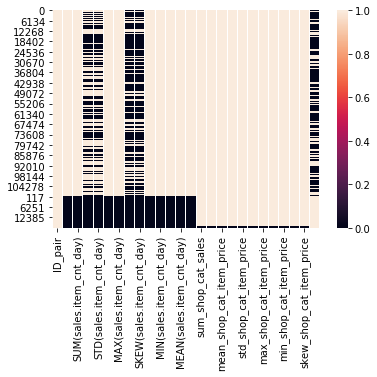

In [112]:
sns.heatmap(~df_joined.isna())

In [117]:
df_joined.head()

,ID_pair,SUM(sales.item_price),SUM(sales.item_cnt_day),STD(sales.item_price),STD(sales.item_cnt_day),MAX(sales.item_price),MAX(sales.item_cnt_day),SKEW(sales.item_price),SKEW(sales.item_cnt_day),MIN(sales.item_price),...,mean_shop_cat_item_price,std_shop_cat_day,std_shop_cat_item_price,max_shop_cat_day,max_shop_cat_item_price,min_shop_cat_day,min_shop_cat_item_price,skew_shop_cat_day,skew_shop_cat_item_price,total_sales
0,10-100,76.0,1.0,NaN,NaN,76.0,1.0,NaN,NaN,76.0,...,147.994286,0.092316,88.523093,2.0,520.0,1.0,27.0,10.707808,0.495648,NaN
1,10-1000,58.0,1.0,NaN,NaN,58.0,1.0,NaN,NaN,58.0,...,200.000000,0.000000,187.735817,1.0,540.0,1.0,58.0,0.000000,0.921525,NaN
2,10-10004,64.0,1.0,NaN,NaN,64.0,1.0,NaN,NaN,64.0,...,147.994286,0.092316,88.523093,2.0,520.0,1.0,27.0,10.707808,0.495648,NaN
3,10-1001,58.0,1.0,NaN,NaN,58.0,1.0,NaN,NaN,58.0,...,200.000000,0.000000,187.735817,1.0,540.0,1.0,58.0,0.000000,0.921525,1.0
4,10-10016,480.0,2.0,0.0,0.0,240.0,1.0,NaN,NaN,240.0,...,147.994286,0.092316,88.523093,2.0,520.0,1.0,27.0,10.707808,0.495648,1.0


# Generating the DataSet 

In [118]:
slots = sales_df['date_block_num'].nunique()

In [119]:
def generateFeatures(sales_df, months_feature, month_target, calculateTarget=True):
    print('features window:',months_feature,', target:',month_target)
    sales_months_df = sales_df[sales_df['date_block_num'].isin(months_feature)]
    sales_result_df = sales_df[sales_df['date_block_num'] == month_target]
    sales_months_df.drop(labels=['date_block_num','shop_id','item_id','item_category_id'], inplace=True, axis=1)
    sales_result_df.drop(labels=['date_block_num','shop_id','item_id','item_category_id'], inplace=True, axis=1)
    
    idsCat = getCatAgg(sales_months_df)
    ids = getItemAgg(sales_months_df)
    target = getTargetAgg(sales_result_df)
    target.head(3)
    
    joined = joinThreeParts(ids, idsCat, target)
    
    # Insert the slot component for correlation purposes
    joined['slot'] = joined['COUNT(sales)'].apply(lambda x: months_feature[-1])
    return joined

In [120]:
def slidingWindow(sales_df, size, slots):
    df_final = pd.DataFrame()
    for index in range(size,slots):
        features_target = generateFeatures(sales_df, np.arange(index-size,index),index)
        # TODO stack dataset
        df_final = pd.concat([df_final,features_target], axis=0) 
    # TODO return completed dataset
    return df_final

## Ensemble Dataset

### Dataset Test

In [121]:
dstest = slidingWindow(sales_df_ensemble, 3,6)

features window: [0 1 2] , target: 3
features window: [1 2 3] , target: 4
features window: [2 3 4] , target: 5


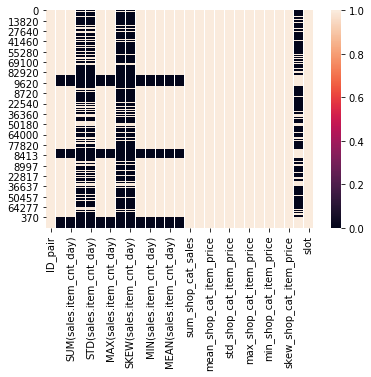

In [122]:
sns.heatmap(~dstest.isna())

In [138]:
dstest[dstest['ID_pair']=='10-1008']

,ID_pair,SUM(sales.item_price),SUM(sales.item_cnt_day),STD(sales.item_price),STD(sales.item_cnt_day),MAX(sales.item_price),MAX(sales.item_cnt_day),SKEW(sales.item_price),SKEW(sales.item_cnt_day),MIN(sales.item_price),...,std_shop_cat_day,std_shop_cat_item_price,max_shop_cat_day,max_shop_cat_item_price,min_shop_cat_day,min_shop_cat_item_price,skew_shop_cat_day,skew_shop_cat_item_price,total_sales,slot
4234,10-1008,176.0,1.0,NaN,NaN,176.0,1.0,NaN,NaN,176.0,...,0.0,309.090762,1.0,1227.0,1.0,58.0,0.0,1.501662,NaN,2
2796,10-1008,176.0,1.0,NaN,NaN,176.0,1.0,NaN,NaN,176.0,...,0.0,315.777344,1.0,1227.0,1.0,58.0,0.0,1.445717,NaN,3
6,10-1008,176.0,1.0,NaN,NaN,176.0,1.0,NaN,NaN,176.0,...,0.0,356.321765,1.0,1227.0,1.0,58.0,0.0,1.212966,NaN,4


In [135]:
dstest[dstest['slot']==4]

,ID_pair,SUM(sales.item_price),SUM(sales.item_cnt_day),STD(sales.item_price),STD(sales.item_cnt_day),MAX(sales.item_price),MAX(sales.item_cnt_day),SKEW(sales.item_price),SKEW(sales.item_cnt_day),MIN(sales.item_price),...,std_shop_cat_day,std_shop_cat_item_price,max_shop_cat_day,max_shop_cat_item_price,min_shop_cat_day,min_shop_cat_item_price,skew_shop_cat_day,skew_shop_cat_item_price,total_sales,slot
0,10-10029,1320.0,1.0,NaN,NaN,1320.0,1.0,NaN,NaN,1320.0,...,0.353553,339.405336,2.0,1320.0,1.0,396.0,2.828427,0.799409,NaN,4
1,10-1003,58.0,1.0,NaN,NaN,58.0,1.0,NaN,NaN,58.0,...,0.000000,356.321765,1.0,1227.0,1.0,58.0,0.000000,1.212966,1.0,4
2,10-10033,110.0,1.0,NaN,NaN,110.0,1.0,NaN,NaN,110.0,...,0.000000,68.196866,1.0,667.0,1.0,58.0,0.000000,2.324389,NaN,4
3,10-1004,174.0,3.0,0.0,0.0,58.0,1.0,0.0,0.0,58.0,...,0.000000,356.321765,1.0,1227.0,1.0,58.0,0.000000,1.212966,1.0,4
4,10-1005,58.0,1.0,NaN,NaN,58.0,1.0,NaN,NaN,58.0,...,0.000000,356.321765,1.0,1227.0,1.0,58.0,0.000000,1.212966,NaN,4
5,10-10057,510.0,2.0,0.0,0.0,255.0,1.0,NaN,NaN,255.0,...,0.133910,87.736899,2.0,520.0,1.0,27.0,7.228441,0.335243,NaN,4
6,10-1008,176.0,1.0,NaN,NaN,176.0,1.0,NaN,NaN,176.0,...,0.000000,356.321765,1.0,1227.0,1.0,58.0,0.000000,1.212966,NaN,4
7,10-10109,70.0,1.0,NaN,NaN,70.0,1.0,NaN,NaN,70.0,...,0.133910,87.736899,2.0,520.0,1.0,27.0,7.228441,0.335243,NaN,4
8,10-10127,138.0,2.0,0.0,0.0,69.0,1.0,NaN,NaN,69.0,...,0.133910,87.736899,2.0,520.0,1.0,27.0,7.228441,0.335243,NaN,4
9,10-10128,55.0,1.0,NaN,NaN,55.0,1.0,NaN,NaN,55.0,...,0.000000,549.398746,1.0,1723.0,1.0,55.0,0.000000,2.736844,NaN,4


In [127]:
dstest

,ID_pair,SUM(sales.item_price),SUM(sales.item_cnt_day),STD(sales.item_price),STD(sales.item_cnt_day),MAX(sales.item_price),MAX(sales.item_cnt_day),SKEW(sales.item_price),SKEW(sales.item_cnt_day),MIN(sales.item_price),...,std_shop_cat_day,std_shop_cat_item_price,max_shop_cat_day,max_shop_cat_item_price,min_shop_cat_day,min_shop_cat_item_price,skew_shop_cat_day,skew_shop_cat_item_price,total_sales,slot
0,0-1000,522.0,9.0,0.0,0.000000,58.0,1.0,0.0,0.000000,58.0,...,0.197019,271.227232,3.0,1227.0,1.0,58.0,9.049307,1.199457,NaN,2
1,0-10004,64.0,1.0,NaN,NaN,64.0,1.0,NaN,NaN,64.0,...,0.797472,87.847731,11.0,520.0,1.0,27.0,5.019103,0.312435,NaN,2
2,0-1001,116.0,2.0,0.0,0.000000,58.0,1.0,NaN,NaN,58.0,...,0.197019,271.227232,3.0,1227.0,1.0,58.0,9.049307,1.199457,NaN,2
3,0-10012,228.0,3.0,0.0,0.000000,76.0,1.0,0.0,0.000000,76.0,...,0.797472,87.847731,11.0,520.0,1.0,27.0,5.019103,0.312435,NaN,2
4,0-1002,116.0,2.0,0.0,0.000000,58.0,1.0,NaN,NaN,58.0,...,0.197019,271.227232,3.0,1227.0,1.0,58.0,9.049307,1.199457,NaN,2
5,0-1003,116.0,2.0,0.0,0.000000,58.0,1.0,NaN,NaN,58.0,...,0.197019,271.227232,3.0,1227.0,1.0,58.0,9.049307,1.199457,NaN,2
6,0-10033,110.0,1.0,NaN,NaN,110.0,1.0,NaN,NaN,110.0,...,0.105521,81.339423,2.0,1242.0,1.0,27.0,9.284512,4.366485,NaN,2
7,0-10038,69.0,1.0,NaN,NaN,69.0,1.0,NaN,NaN,69.0,...,0.797472,87.847731,11.0,520.0,1.0,27.0,5.019103,0.312435,NaN,2
8,0-1004,174.0,3.0,0.0,0.000000,58.0,1.0,0.0,0.000000,58.0,...,0.197019,271.227232,3.0,1227.0,1.0,58.0,9.049307,1.199457,NaN,2
9,0-10048,188.0,1.0,NaN,NaN,188.0,1.0,NaN,NaN,188.0,...,0.797472,87.847731,11.0,520.0,1.0,27.0,5.019103,0.312435,NaN,2


In [15]:
windows = [3,6,12,18,25,32]

### Dataset 1

In [ ]:
dataset1A = slidingWindow(sales_df_ensemble, windows[0], slots)
dataset1B = slidingWindow(sales_df_stacking, windows[0], slots)

In [ ]:
dataset1A.to_csv('../datasets/predict-sales/dataset1A.csv')
dataset1B.to_csv('../datasets/predict-sales/dataset1B.csv')

### Dataset 2

In [ ]:
dataset2A = slidingWindow(sales_df_ensemble, windows[1], slots)
dataset2B = slidingWindow(sales_df_stacking, windows[1], slots)

In [ ]:
dataset2A.to_csv('datasets/predict-sales/dataset2A.csv')
dataset2B.to_csv('datasets/predict-sales/dataset2B.csv')

### Dataset 3

In [ ]:
dataset3A = slidingWindow(sales_df_ensemble, windows[2], slots)
dataset3B = slidingWindow(sales_df_stacking, windows[2], slots)

In [ ]:
dataset3A.to_csv('../datasets/predict-sales/dataset3A.csv')
dataset3B.to_csv('../datasets/predict-sales/dataset3B.csv')

### Dataset 4

In [ ]:
dataset4A = slidingWindow(sales_df_ensemble, windows[3], slots)
dataset4B = slidingWindow(sales_df_stacking, windows[3], slots)

In [ ]:
dataset4A.to_csv('../datasets/predict-sales/dataset4A.csv')
dataset4B.to_csv('../datasets/predict-sales/dataset4B.csv')

### Dataset 5

In [ ]:
dataset5A = slidingWindow(sales_df_ensemble, windows[4],slots)
dataset5B = slidingWindow(sales_df_stacking, windows[4],slots)

In [ ]:
dataset5A.to_csv('../datasets/predict-sales/dataset5A.csv')
dataset5B.to_csv('../datasets/predict-sales/dataset5B.csv')

### Dataset 6

In [ ]:
dataset6A = slidingWindow(sales_df_ensemble, windows[5],slots)
dataset6B = slidingWindow(sales_df_stacking, windows[5],slots)

In [ ]:
dataset6A.to_csv('../datasets/predict-sales/dataset6A.csv')
dataset6B.to_csv('../datasets/predict-sales/dataset6B.csv')

## Stacking Dataset 

In [ ]:
# TODO

# End of Case! 